In [ ]:
!pip install -U -q transformers datasets pythainlp

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from transformers import AutoTokenizer, AutoModelForTokenClassification, CamembertTokenizer, CamembertForSequenceClassification
import re
from pythainlp.tokenize import word_tokenize
import torch
from tqdm import tqdm
import random
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback, IntervalStrategy
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer

2024-05-08 17:36:44.497691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 17:36:44.497789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 17:36:44.602302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [36]:
ner_tokenizer = AutoTokenizer.from_pretrained(
    "pythainlp/thainer-corpus-v2-base-model")
ner_model = AutoModelForTokenClassification.from_pretrained(
    "pythainlp/thainer-corpus-v2-base-model")

In [2]:
def fix_span_error(words,ner):
    _ner = []
    _ner=ner
    _new_tag=[]
    
    for i,j in zip(words,_ner):
        i=tokenizer.decode(i)
        if i.isspace() and j.startswith("B-"):
            j="O"
        if i=='' or i=='<s>' or i=='</s>':
            continue
        if i=="<_>":
            i=" "
        _new_tag.append((i,j))
    return _new_tag

def clean_pipeline(text):
    text = text.replace("สํา", "สำ")
    text = re.sub("(สามารถ|)(ลง|)ลาย(มือ|)ชื่อ(ของ|)", "", text)
    text = re.sub("(และ|)ประทับตราสำคัญของบริษัท", "", text)
    text = re.sub("(และ|พร้อม|)ประทับตราสำคัญของบริษัท", "", text)
    text = re.sub("(และ|)ประทับตราบริษัท(เป็นสำคัญ|)", "", text)
    text = re.sub("(และ|)ผูกพันบริษัท", "", text)
    
    return text

def get_ner_tag(text: str):
    cut=word_tokenize(text.replace(" ", "<_>"))
    inputs=ner_tokenizer(cut,is_split_into_words=True,return_tensors="pt")

    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    # forward pass
    outputs = ner_model(ids, attention_mask=mask)
    logits = outputs[0]

    predictions = torch.argmax(logits, dim=2)
    predicted_token_class = [ner_model.config.id2label[t.item()] for t in predictions[0]]

    ner_tag=fix_span_error(inputs['input_ids'][0],predicted_token_class)
    return ner_tag

def clean_ner_tag(ner_tag):
    # Clean PERSON tag
    new_ner_tag = []
    prev_tag = ner_tag[0][1]

    for i, tag in enumerate(ner_tag):
        new_tag = tag[1]
        if tag[1] == "I-PERSON" and not (prev_tag == "B-PERSON" or prev_tag == "I-PERSON"):
            new_tag = "O"
        if tag[1] == "O" and (prev_tag == "B-PERSON" or prev_tag == "I-PERSON") and i+1 < len(ner_tag):
            if ner_tag[i+1][1] == "I-PERSON":
                new_tag = "I-PERSON"
            
        new_ner_tag.append((tag[0], new_tag))
        prev_tag = new_tag

    return new_ner_tag

def get_symbolic_context(ner_tag) -> str:
    last_context = ""
    prev = "O"
    current = []
    
    for tag in new_ner_tag:
        if tag[1] == "B-PERSON":
            if prev == "I-PERSON":
                last_context += "</p>"
            last_context += "<p>" + tag[0]
            continue
        
        if tag[1] != prev and prev == "I-PERSON":
            last_context += "</p>"
        last_context += tag[0]
        prev = tag[1]
    
    if prev == "I-PERSON":
        last_context += "</p>"
        
    return last_context

def get_clean_context_and_people_list(context):
    context = re.sub(r"</p>(.{0,8})<p>", r"\1", context)
    people_list = re.findall("<p>(.*?)</p>", context)
    context = re.sub("(<p>.*?</p>)", "<p>", context)
    context = re.sub("</p>", "", context)
    
    return context, people_list

def get_name_from_committee(rgno, committee_df):
    sample = committee_df[committee_df['rgno'] == rgno]
    names = []
    
    for idx, row in sample.iterrows():
        names.append(row['title'] + row['fname'] + " " + row['lname'])
    name_text = "".join(names)
    return name_text

def preprocess_context(context, rgno, committee_df):
    name = get_name_from_committee(rgno, committee_df)
    context = re.sub("(กรรมการคนใดคนหนึ่ง|กรรมการอื่นอีก)", name, context)
    return context

In [ ]:
df = pd.read_csv("/kaggle/input/legal-act-classification/train.csv")
df['difficultly'] = df['pattern'].apply(lambda x: str(x)[0])

commitee = pd.read_csv("/kaggle/input/legal-act-classification/committee.csv", index_col=0)

In [ ]:
"""

    Preprocess Training data

"""

train_data_list = []
train_answers_list = []

for idx in tqdm(range(len(df))):
    try: 
        context = df.iloc[idx].context
        rgno = df.iloc[idx].rgno
        
        context = preprocess_context(context, rgno, commitee)
        ner_tag = get_ner_tag(context)
        new_ner_tag = clean_ner_tag(ner_tag)
        
    except RuntimeError:
        continue
    
    last_context = get_symbolic_context(new_ner_tag)
    last_context, people_list = get_clean_context_and_people_list(last_context)

    num_p_tag = last_context.count("<p>")
    inputs = df.iloc[idx].question
    inputs = inputs.replace("[", "").replace("]", "").replace("\'", "")
    inputs = inputs.split(", ")
    
    people_joined = []
    for i in range(num_p_tag):
        count = 0
        for name in inputs:
            if name.replace(" ", "") in people_list[i].replace(" ", ""):
                count += 1
                people_joined.append(name.replace(" ", ""))

        _idx = last_context.find("<p>")
        last_context = last_context[:_idx] + f" <p{count}> " + last_context[_idx+len("<p>"):]

    last_context += f" <มีอำนาจ{len(set(people_joined))}คนจาก{count}คน>"
    last_context = re.sub(" +", " ", last_context.strip())
    # print(last_context)
    train_data_list.append(last_context)
    train_answers_list.append(df.iloc[idx].answer)

In [ ]:
clean_data_list = [clean_pipeline(text).replace("พรมฝ้าย", "") for text in train_data_list]

In [ ]:
train = pd.DataFrame({"input": clean_data_list, "output": train_answers_list})

In [ ]:
train.to_csv("train.csv", index=False)

In [ ]:
train = train.drop_duplicates()

In [ ]:
train

In [ ]:
train['token'] = train['input'].apply(lambda x: len(tokenizer(x)['input_ids']))

In [ ]:
train['token'].hist()

In [ ]:
train['token'].max()

## Training

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import random
# from transformers import AutoModel, AutoTokenizer
# import re
# from pythainlp.tokenize import word_tokenize # pip install pythainlp
# import torch
# from tqdm import tqdm
# import random

In [75]:
model = CamembertForSequenceClassification.from_pretrained(
    "airesearch/wangchanberta-base-att-spm-uncased")
tokenizer = CamembertTokenizer.from_pretrained(
    "airesearch/wangchanberta-base-att-spm-uncased")

In [ ]:
# mask = train['input'].apply(lambda x: "1)" not in x)
# train['token'] = train['input'].apply(lambda x: len(tokenizer(x)['input_ids']))
# train = train[mask]
# train = train.drop_duplicates()

In [6]:
TOKEN = 162

In [74]:
mask = train['input'].apply(lambda x: "1)" not in x)
train['token'] = train['input'].apply(lambda x: len(tokenizer(x)['input_ids']))
train = train[mask]
# train = pd.read_csv("/kaggle/working/train.csv")

/tmp/ipykernel_2122/3016276109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['token'] = train['input'].apply(lambda x: len(tokenizer(x)['input_ids']))


In [60]:
train = train.drop_duplicates()

In [76]:
train

,input,output,token
0,<p1> ร่วมกับ <p1> หนึ่งคนรวมเป็นสองคน <มีอำนาจ...,0,27
6,<p0> ร่วมกับ <p0> หนึ่งคนรวมเป็นสองคน <มีอำนาจ...,0,27
7,<p2> ร่วมกับ <p2> หนึ่งคนรวมเป็นสองคน <มีอำนาจ...,1,27
12,<p1> ร่วมกับ <p1> หนึ่งคนรวมเป็นสองคน <มีอำนาจ...,1,27
49,<p3> ร่วมกับ <p3> หนึ่งคนรวมเป็นสองคน <มีอำนาจ...,1,27
...,...,...,...
4217,<p1> กรรมการกลุ่ม 1 <p1> กรรมการกลุ่ม 2 <p1> ก...,1,53
4220,<p2> กรรมการกลุ่ม 1 <p0> กรรมการกลุ่ม 2 <p1> ก...,0,53
4226,<p2> กรรมการกลุ่ม 1 <p1> กรรมการกลุ่ม 2 <p0> ก...,0,53
4242,<p0> กรรมการกลุ่ม 1 <p0> กรรมการกลุ่ม 2 <p0> ก...,0,53


In [77]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        encode = self.tokenizer(
            self.dataframe.iloc[idx]['input'],
            max_length=TOKEN,
            truncation=True,
            padding='max_length'
        )
        label = self.dataframe.iloc[idx]['output']
        encode['labels'] = torch.tensor(label)
        return encode

In [78]:
train = train.drop_duplicates()
train_dataset = CustomImageDataset(train, tokenizer)

In [ ]:
# import os
# import pandas as pd
# import torch
# from torch.utils.data import Dataset
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader
# from transformers import TrainingArguments
# from transformers import EarlyStoppingCallback, IntervalStrategy
# from sklearn.metrics import accuracy_score, f1_score
# from transformers import Trainer

In [79]:
# Set Batch Size
batch_size = 32
logging_steps = 50 #len(df) // batch_size
num_train_epochs = 20
lr_initial = 2e-5
weight_decay = 1e-3
output_dir = "modelv2"

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    learning_rate=lr_initial,
    per_device_train_batch_size=batch_size,
    # per_device_eval_batch_size=batch_size,
    weight_decay=weight_decay,
    # evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [80]:
args = TrainingArguments(
   output_dir=output_dir,
   save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
)

In [81]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [82]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    tokenizer=tokenizer
)

In [83]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
50,0.601600
100,0.565400
150,0.502500


TrainOutput(global_step=180, training_loss=0.5457844681209988, metrics={'train_runtime': 165.8621, 'train_samples_per_second': 62.944, 'train_steps_per_second': 1.085, 'total_flos': 869129815838400.0, 'train_loss': 0.5457844681209988, 'epoch': 20.0})

In [21]:
model.save_pretrained("model_bertv4")

## Vis

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.manifold import TSNE

dim_reducer = TSNE(n_components=2)

def visualize_layerwise_embeddings(hidden_states,masks,labels,epoch,title,layers_to_visualize):

    !mkdir -p /tmp/plots/{title}
    num_layers = len(layers_to_visualize)
    
    fig = plt.figure(figsize=(24,(num_layers/4)*6)) #each subplot of size 6x6, each row will hold 4 plots
    print(f'Creating {num_layers} subplots')
    ax = [fig.add_subplot(num_layers//4,4,i+1) for i in range(num_layers)]
    
    labels = labels.detach().numpy().reshape(-1)
    for i,layer_i in enumerate(layers_to_visualize):
        layer_embeds = hidden_states[layer_i]
        
        layer_averaged_hidden_states = torch.div(layer_embeds.sum(dim=1),masks.sum(dim=1,keepdim=True))
        layer_dim_reduced_embeds = dim_reducer.fit_transform(layer_averaged_hidden_states.detach().numpy())
        
        df = pd.DataFrame.from_dict({'x':layer_dim_reduced_embeds[:,0],'y':layer_dim_reduced_embeds[:,1],'label':labels})
        
        sns.scatterplot(data=df,x='x',y='y',hue='label',ax=ax[i])

    
    plt.savefig(f'{title}',format='png',pad_inches=0)

In [23]:
model.eval()
model.to("cpu")

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(25005, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [25]:
random_df = train.sample(frac=0.3)
random_df

,input,output
2675,1) <p1> กรรมการสองในห้าคนนี้ร่วมกัน 2) <p1> ร่...,1
3277,<p1> มีอํานาจและประทับตราของบริษัท <มีอำนาจ1คน...,1
2885,กรรมการสองในสามคนนี้ร่วมกัน <มีอำนาจ0คนจาก0คน>,1
1735,<p2> ร่วมกันกับ <p0> <มีอำนาจ2คนจาก0คน>,0
3049,กรรมการสองในหกคนนี้ร่วมกัน <มีอำนาจ0คนจาก0คน>,0
...,...,...
2613,<p2> ร่วมกับ <p1> รวมเป็น 2 คนหรือ <p1> รักษ์ร...,0
2024,กลุ่ม (ก) 1. <p0> ร์กลุ่ม (ข) 1. <p0> กรรมการก...,0
2280,<p1> กรรมการสองในสี่คนนี้ร่วมกันหรือ <p0> กรรม...,1
1652,1. <p1> ร่วมกับ <p2> รวมเป็นสองคน 2. <p0> ได้เ...,1


<Axes: >

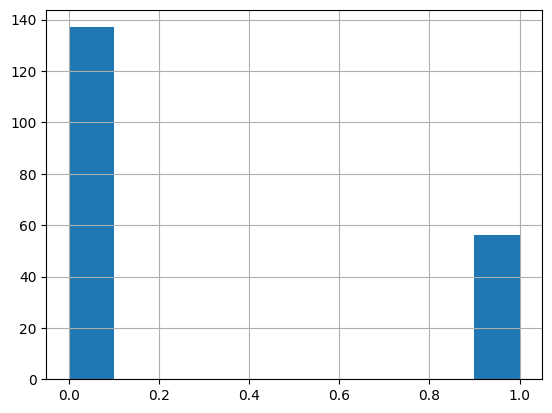

In [26]:
random_df.output.hist()

In [27]:
tokens = tokenizer(
    random_df['input'].tolist(),
    return_tensors="pt",
    max_length=TOKEN,
    truncation=True,
    padding='max_length'
)

# tokens

In [28]:
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']

model_out = model(input_ids,attention_mask,output_hidden_states=True,return_dict=True)
hidden_states = model_out.hidden_states[1:]

Creating 8 subplots


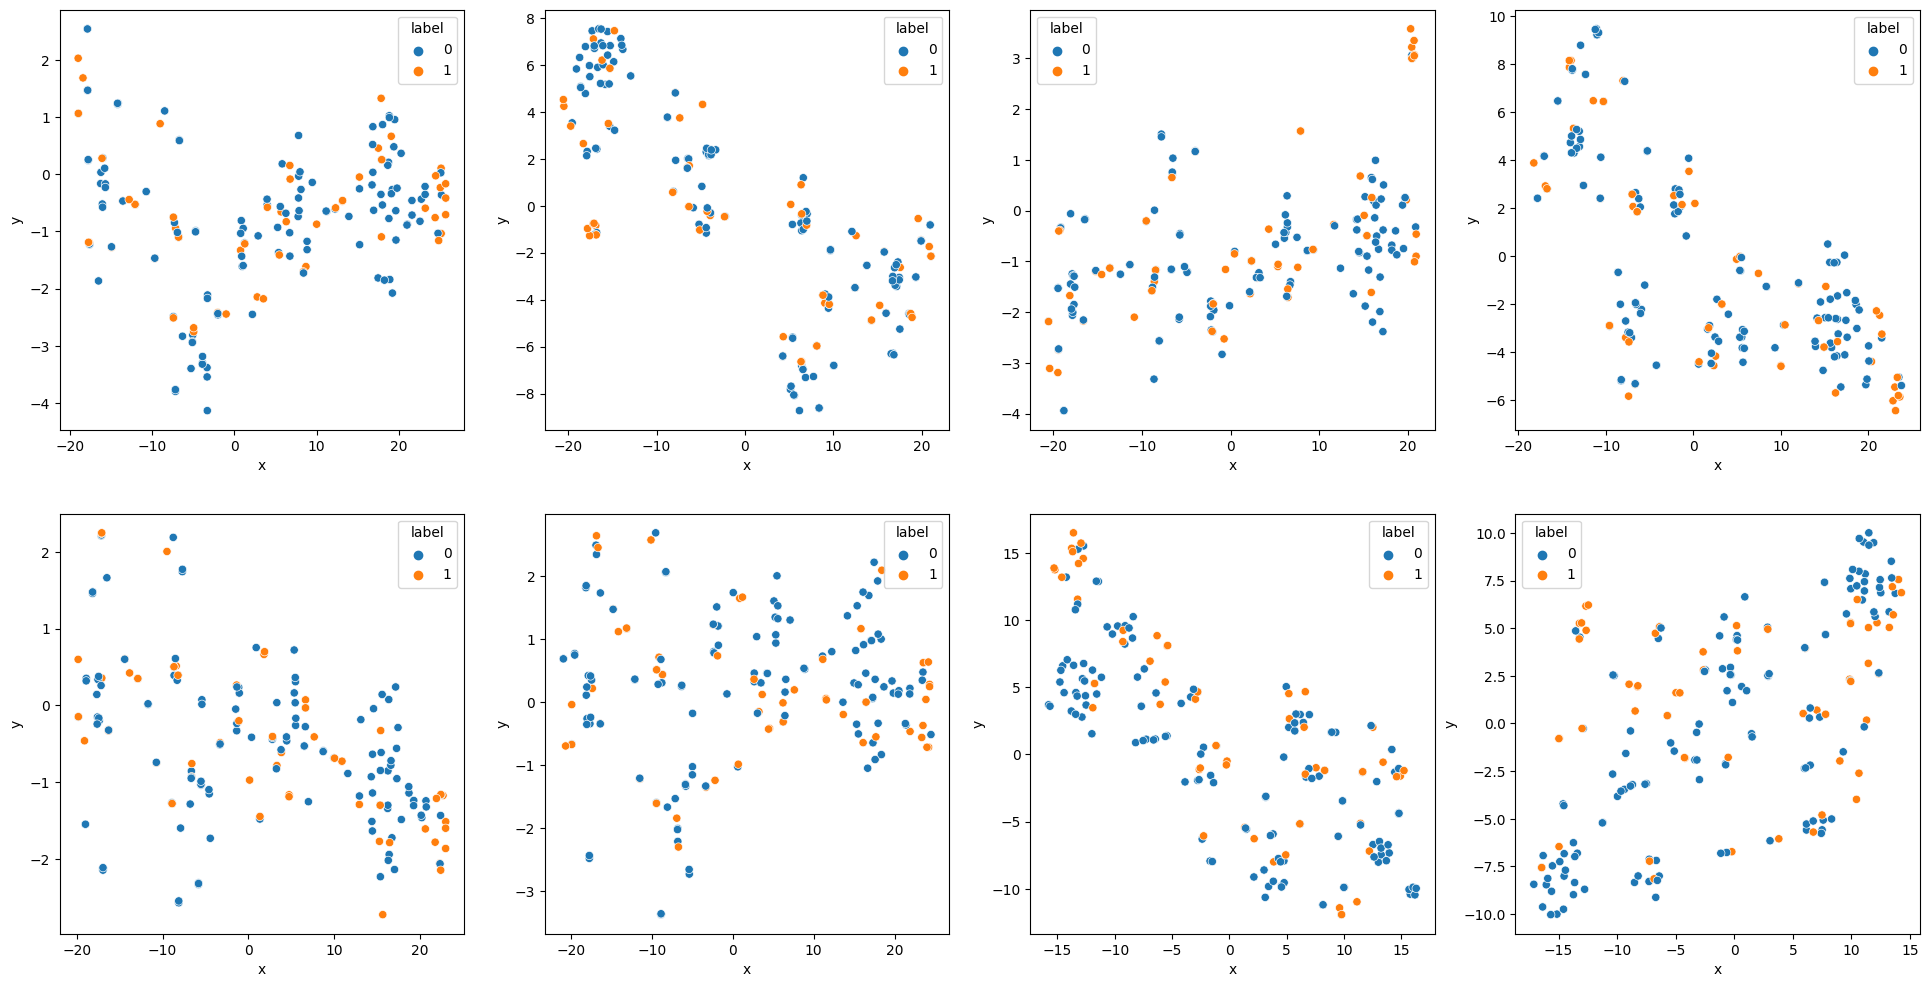

In [29]:
visualize_layerwise_embeddings(
      hidden_states=hidden_states,
      masks=attention_mask,
      labels=torch.tensor(random_df['output'].tolist()),
      epoch=15,
      title='train_data',
      layers_to_visualize=[0, 1, 2, 3, 8, 9, 10, 11]
)

## Test

In [84]:
model.eval()

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(25005, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [85]:
df = pd.read_csv("/kaggle/input/legal-act-classification/test.csv")
commitee = pd.read_csv("/kaggle/input/legal-act-classification/committee.csv", index_col=0)

In [86]:
df

,id,rgno,context,pattern,question,legal_act,condition
0,0,105510003412,ลายมือชื่อของกรรมการคนใดคนหนึ่งลงลายมือชื่อ เป...,11015,['สหชา อินทร์ไชย'],การขอวีซ่า,NaN
1,1,105510003412,ลายมือชื่อของกรรมการคนใดคนหนึ่งลงลายมือชื่อ เป...,11015,['สุเมธ คุ้มคง'],การค้ำประกัน,NaN
2,2,105510003412,ลายมือชื่อของกรรมการคนใดคนหนึ่งลงลายมือชื่อ เป...,11015,['ภควัฒน์ ผาสุข'],ใบอนุญาตจำหน่ายสุราและจำหน่ายยาสูบ,NaN
3,3,105510003412,ลายมือชื่อของกรรมการคนใดคนหนึ่งลงลายมือชื่อ เป...,11015,['อชิระ อาจนาเสียว'],ธนาคาร,NaN
4,4,105510003412,ลายมือชื่อของกรรมการคนใดคนหนึ่งลงลายมือชื่อ เป...,11015,['ณัฐวีร์ แนวกำพล'],มัคคุเทศน์,NaN
...,...,...,...,...,...,...,...
5830,5830,105562113421,กรรมการคนใดคนหนึ่งของกรรมการกลุ่ม ก. ลงลายมือช...,20004,"['กฤตภาส หาญช้าง', 'กัมปนาท สุนทรธรรม', 'ตุลย์...",ธุรกิจนำเที่ยว,NaN
5831,5831,105562113421,กรรมการคนใดคนหนึ่งของกรรมการกลุ่ม ก. ลงลายมือช...,20004,"['กฤตภาส หาญช้าง', 'พิชญะ แสงรุ่งคงคา', 'ตุลย์...",มัคคุเทศน์,NaN
5832,5832,105562113421,กรรมการคนใดคนหนึ่งของกรรมการกลุ่ม ก. ลงลายมือช...,20004,"['ณัฐกานต์ โคตรยอด', 'กฤตภาส หาญช้าง', 'ตุลย์ ...",การทำนิติกรรม กรมที่ดิน,NaN
5833,5833,105562113421,กรรมการคนใดคนหนึ่งของกรรมการกลุ่ม ก. ลงลายมือช...,20004,"['กฤตภาส หาญช้าง', 'วรนัยน์ นางาซาวา', 'ตุลย์ ...",การทำนิติกรรม สำนักงานส่งเริมการลงทุน,NaN


In [37]:
"""

    Preprocess Testing data

"""

test_data_list = []

for idx in tqdm(range(len(df))):
    try: 
        context = df.iloc[idx].context
        rgno = df.iloc[idx].rgno
        
        context = preprocess_context(context, rgno, commitee)
        ner_tag = get_ner_tag(context)
        new_ner_tag = clean_ner_tag(ner_tag)
        
    except RuntimeError:
        inputs = df.iloc[idx].question
        inputs = inputs.replace("[", "").replace("]", "").replace("\'", "")
        inputs = inputs.split(", ")
        test_data_list.append(f"จาก{len(inputs)}คน")
        continue
    
    last_context = get_symbolic_context(new_ner_tag)
    last_context, people_list = get_clean_context_and_people_list(last_context)

    num_p_tag = last_context.count("<p>")
    inputs = df.iloc[idx].question
    inputs = inputs.replace("[", "").replace("]", "").replace("\'", "")
    inputs = inputs.split(", ")
    
    people_joined = []
    for i in range(num_p_tag):
        count = 0
        for name in inputs:
            if name.replace(" ", "") in people_list[i].replace(" ", ""):
                count += 1
                people_joined.append(name.replace(" ", ""))

        _idx = last_context.find("<p>")
        last_context = last_context[:_idx] + f" <p{count}> " + last_context[_idx+len("<p>"):]

    last_context += f" <มีอำนาจ{len(set(people_joined))}คนจาก{count}คน>"
    last_context = re.sub(" +", " ", last_context.strip())
    test_data_list.append(last_context)

100%|██████████| 5835/5835 [27:27<00:00,  3.54it/s]


In [38]:
clean_test_data_list = [clean_pipeline(text) for text in test_data_list]

In [39]:
pd.DataFrame({"input": clean_test_data_list}).to_csv("test.csv")

In [91]:
test_df = pd.read_csv("/kaggle/working/test.csv")
clean_test_data_list = test_df['input'].tolist()

In [87]:
model.eval()
model.to("cuda")

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(25005, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [93]:
prediction = []

for i in tqdm(range(0, len(clean_test_data_list), 15)):
    tokens = tokenizer(
        clean_test_data_list[i : i + 15],
        return_tensors="pt",
        max_length=TOKEN,
        truncation=True,
        padding='max_length'
    ).to("cuda")

    outputs = model(**tokens)
    preds = torch.argmax(outputs.logits, dim=1)
    prediction.extend(preds.detach().cpu().numpy().tolist())

100%|██████████| 389/389 [00:57<00:00,  6.73it/s]


In [94]:
submission = pd.read_csv("/kaggle/input/legal-act-classification/sample_submission.csv")
submission

,id,answer
0,0,1.0
1,1,1.0
2,2,1.0
3,3,NaN
4,4,NaN
...,...,...
5830,5830,NaN
5831,5831,NaN
5832,5832,NaN
5833,5833,NaN


In [95]:
submission['answer'].iloc[3:] = prediction[3:]

/tmp/ipykernel_2122/1565659449.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  submission['answer'].iloc[3:] = prediction[3:]
/tmp/ipykernel_2122/1565659449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [96]:
submission['answer'].value_counts()

answer
0.0    4362
1.0    1473
Name: count, dtype: int64

In [98]:
submission['answer'] = submission['answer'].astype(int)

In [99]:
submission

,id,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
5830,5830,0
5831,5831,0
5832,5832,0
5833,5833,0


In [100]:
submission.to_csv("bertv5.csv", index=False)

In [ ]:
clean_test_data_list[5814]